In [52]:
import numpy as np
import pandas as pd
import string
import pickle

import sklearn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize

import random

random_state = 0
np.random.seed(random_state)
random.seed(random_state)

In [53]:
sklearn.__version__

'0.20.1'

## Data Loading and Splits

In [54]:
filename = '../../data/final_annotated_data.csv'
df = pd.read_csv(filename)

print(df.is_answerable_orig.value_counts())
print('Total', len(df))

N    1754
Y    1094
S    1074
Name: is_answerable_orig, dtype: int64
Total 3922


In [55]:
# Column Renames
cols = ['question', 'review0', 'review1', 'review2', 'review3', 'review4', 'is_answerable', 'is_answerable_human', 'expert']
df = df.rename(columns={'is_answerable_orig': 'is_answerable', 'is_answerable_new': 'is_answerable_human'})[cols]

def filter_data(df):
    df = df[df.is_answerable.notnull()]
    df = df[df.review0.notnull()]
    return df

L = len(df)
df = filter_data(df)
assert L == len(df)


label_map = {'N': 0, 'S': 1, 'Y': 1}

def label_func(df):
    df['label'] = df.is_answerable.apply(lambda x: label_map[x])

label_func(df)

In [56]:
def print_stats(df, name='df'):
    print(name.upper())
    print('Length = %d' % len(df))
    print('IsAnswerable Counts')
    print(df.is_answerable.value_counts() / len(df))
    print('IsAnswerableHuman Counts')
    print(df.is_answerable_human.value_counts()  / len(df))
    print()

In [57]:
"""
test_df = df[df.expert]
train_df_part1 = df[~df.expert]

test_df_part1 = test_df[test_df.is_answerable_human.notnull()]
expert_rest_df = test_df[test_df.is_answerable_human.isnull()]

val_df, test_df_part2, train_df_part2 = np.split(expert_rest_df.sample(frac=1), [200, 270])

train_df = pd.concat([train_df_part1, train_df_part2]).sample(frac=1)
test_df = pd.concat([test_df_part1, test_df_part2]).sample(frac=1)
"""

non_expert_df = df[~df.expert]
expert_df = df[df.expert]
test_df = expert_df[expert_df.is_answerable_human.notnull()]

train_df, val_df = np.split(non_expert_df.sample(frac=1, random_state=random_state), [int(0.9*len(non_expert_df))])

print_stats(train_df, 'train')
print_stats(val_df, 'val')
print_stats(test_df, 'test')


TRAIN
Length = 2967
IsAnswerable Counts
N    0.425008
S    0.289181
Y    0.285811
Name: is_answerable, dtype: float64
IsAnswerableHuman Counts
Series([], Name: is_answerable_human, dtype: float64)

VAL
Length = 330
IsAnswerable Counts
N    0.409091
Y    0.309091
S    0.281818
Name: is_answerable, dtype: float64
IsAnswerableHuman Counts
Series([], Name: is_answerable_human, dtype: float64)

TEST
Length = 135
IsAnswerable Counts
N    0.481481
Y    0.362963
S    0.155556
Name: is_answerable, dtype: float64
IsAnswerableHuman Counts
N    0.422222
Y    0.392593
S    0.185185
Name: is_answerable_human, dtype: float64



In [58]:
def get_reviews(row):
    all_reviews = ''
    for key in ['review0', 'review1', 'review2', 'review3', 'review4']:
        if not isinstance(row[key], float):
            all_reviews += row[key].strip(' ').strip('-')
            all_reviews += ' '
    return all_reviews.strip()


def add_reviews(df):
    df['reviews'] = df.apply(lambda x: get_reviews(x), axis = 1)
    return df


train_df, test_df, val_df = list(map(add_reviews, [train_df, test_df, val_df]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


## TF IDF Vectorizer

In [9]:
"""
df = pd.read_csv('../../data/train-qar_sample_100000.csv')
df = add_reviews(df)
print(len(df))

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))

with open('../../data/tfidf_vectorizer.pkl', 'wb') as fp:
    pickle.dump(tfidf_vectorizer, fp)
"""

"\ndf = pd.read_csv('../../data/train-qar_sample_100000.csv')\ndf = add_reviews(df)\nprint(len(df))\n\ntfidf_vectorizer = TfidfVectorizer(stop_words='english')\ntfidf_vectorizer.fit(list(df.question.values) + list(df.reviews.values))\n\nwith open('../../data/tfidf_vectorizer.pkl', 'wb') as fp:\n    pickle.dump(tfidf_vectorizer, fp)\n"

In [59]:
with open('../../data/tfidf_vectorizer.pkl', 'rb') as fp:
    tfidf_vectorizer = pickle.load(fp)

In [60]:
len(tfidf_vectorizer.vocabulary_)

158752

## w2v Vectorizer

In [61]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = 300

    def fit(self, X):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [62]:
with open('../../data/w2v_vectorizer.pkl', 'rb') as fp:
    w2v_vectorizer = pickle.load(fp)

In [14]:
"""
import numpy as np

with open("../../data/glove.6B.300d.txt", "rb") as lines:
    w2v = {str(line.split()[0].decode('UTF-8')): np.array(list(map(float, line.split()[1:])))
           for line in lines}

w2v_vectorizer = MeanEmbeddingVectorizer(w2v)
with open('../../data/w2v_vectorizer.pkl', 'wb') as fp:
    pickle.dump(w2v_vectorizer, fp)
"""

'\nimport numpy as np\n\nwith open("../../data/glove.6B.300d.txt", "rb") as lines:\n    w2v = {str(line.split()[0].decode(\'UTF-8\')): np.array(list(map(float, line.split()[1:])))\n           for line in lines}\n\nw2v_vectorizer = MeanEmbeddingVectorizer(w2v)\nwith open(\'../../data/w2v_vectorizer.pkl\', \'wb\') as fp:\n    pickle.dump(w2v_vectorizer, fp)\n'

## Features

In [63]:
train_df_raw, test_df_raw, val_df_raw = list(map(lambda x: x.copy(), [train_df, test_df, val_df]))

In [64]:
def tokenize(text):
    punctuations = string.punctuation.replace("\'", '')

    for ch in punctuations:
        text = text.replace(ch, " " + ch + " ")

    tokens = text.split()
    for i, token in enumerate(tokens):
        if not token.isupper():
            tokens[i] = token.lower()
    return tokens

In [65]:
"""
x = vectorizer.transform(['It is a total idiot'])
y = vectorizer.transform(['It is not a total idiocy'])

print(type(x), '|\n', x.shape, '|\n', x, '|\n', len(x.toarray()[0]))
print("-"*50)
print(type(y), '|\n', y.shape, '|\n', y, '|\n', len(y.toarray()[0]))
print("-"*50)
print(x.toarray().dot(y.toarray().transpose())[0][0])
"""

'\nx = vectorizer.transform([\'It is a total idiot\'])\ny = vectorizer.transform([\'It is not a total idiocy\'])\n\nprint(type(x), \'|\n\', x.shape, \'|\n\', x, \'|\n\', len(x.toarray()[0]))\nprint("-"*50)\nprint(type(y), \'|\n\', y.shape, \'|\n\', y, \'|\n\', len(y.toarray()[0]))\nprint("-"*50)\nprint(x.toarray().dot(y.toarray().transpose())[0][0])\n'

In [66]:
def n_intersection(q, r):
    return len(set(q).intersection(set(r)))

def w2v_sim(q, r):
    # dot product of q and r as w2v vectors
    q_vec = w2v_vectorizer.transform([q])
    r_vec = w2v_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose())[0][0]

def tf_idf_sim(q, r):
    # dot product of q and r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    r_vec = tfidf_vectorizer.transform([r])
    return q_vec.dot(r_vec.transpose()).toarray()[0][0]

def tf_idf_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return max([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def tf_idf_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = tfidf_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(tfidf_vectorizer.transform([r]).transpose()).toarray()[0][0] for r in rs])

def w2v_sim_sentence_mean(q, rs):
    # max of dot products of q and each sentence in r as tfidf vectors
    q_vec = w2v_vectorizer.transform([q])
    if len(rs) == 0:
        return 0
    return np.mean([q_vec.dot(w2v_vectorizer.transform([r]).transpose())[0][0] for r in rs])

def add_features(df):
    df['q_tokens']       = df.question.apply(lambda x: tokenize(x))
    df['r_tokens']       = df.reviews.apply(lambda x: tokenize(x))
    df['r_sents']        = df.reviews.apply(lambda x: sent_tokenize(x))
    df['n_q']            = df.q_tokens.apply(lambda x: len(x))
    df['n_r']            = df.r_tokens.apply(lambda x: len(x))
    df['n_intersection'] = df.apply(lambda x: len(set(x.q_tokens).intersection(set(x.r_tokens))), axis=1)
    df['intr_frac']      = df.n_intersection / df.n_q
    df['tfidf']          = df.apply(lambda x: tf_idf_sim(x.question, x.reviews), axis=1)
    df['w2v']            = df.apply(lambda x: w2v_sim(x.question, x.reviews), axis=1)
    df['w2v_sent']       = df.apply(lambda x: w2v_sim_sentence(x.question, x.r_sents), axis=1)
    df['tfidf_sent']     = df.apply(lambda x: tf_idf_sim_sentence(x.question, x.r_sents), axis=1)
    df['w2v_sent_mean']  = df.apply(lambda x: w2v_sim_sentence_mean(x.question, x.r_sents), axis=1)
    df['tfidf_sent_mean']= df.apply(lambda x: tf_idf_sim_sentence_mean(x.question, x.r_sents), axis=1)
    return df


In [67]:
train_df, test_df, val_df = list(map(add_features, [train_df_raw, test_df_raw, val_df_raw]))

In [68]:
for typ, df in [('train', train_df), ('test', test_df), ('val', val_df)]:
    pickle.dump(df, open('../../data/' + typ + '_df_features.pkl', 'wb'))

train_df_raw, test_df_raw, val_df_raw = None, None, None

## Feature Cols

In [69]:
X_cols = ['n_q', 'n_r', 'n_intersection', 'intr_frac']
Y_cols = 'label'

## Analysis

In [70]:
#train_df = pickle.load(open('../../data/' + 'train' + '_df_features.pkl', 'rb'))
#test_df = pickle.load(open('../../data/' + 'test' + '_df_features.pkl', 'rb'))
#val_df = pickle.load(open('../../data/' + 'val' + '_df_features.pkl', 'rb'))

In [71]:
df = train_df

q = df.question.iloc[1]
r = df.reviews.iloc[1]
q_tokens = df.q_tokens.iloc[1]
r_tokens = df.r_tokens.iloc[1]

# q, r, set(q_tokens).intersection(set(r_tokens))

In [72]:
df[[Y_cols] + X_cols].groupby(Y_cols).mean()

,n_q,n_r,n_intersection,intr_frac
label,,,,
0,15.646312,329.911975,7.099921,0.469958
1,17.426729,379.018171,9.582649,0.583118


## Training

In [73]:
train_df.head()

,question,review0,review1,review2,review3,review4,is_answerable,is_answerable_human,expert,label,...,n_q,n_r,n_intersection,intr_frac,tfidf,w2v,w2v_sent,tfidf_sent,w2v_sent_mean,tfidf_sent_mean
2465,"Does it have a strong smell, I don't want my d...","i live in front of deep wooded area, and get s...",I live in a basement so I'm pretty used to see...,Wonderful! I suggest you have a non-spider fea...,I was like the majority of you reading these r...,I put these traps by the wall near entry point...,Y,NaN,False,1,...,15,458,10,0.666667,0.102567,17.747450,18.787045,0.208506,17.778122,0.032126
33,Does this camera work with windows 8?,"You can rotate the picture on the camera, or u...","But, I think I was using the old rechargeables...",~ The battery and memory chamber door broke on...,Dramatically.You can make high quality videos ...,I am really disappointed in this camera. I wan...,N,NaN,False,0,...,8,414,4,0.500000,0.323437,17.109193,17.384769,0.379328,16.934596,0.147939
712,Can we use this on GE gas cooktops?,We have a Wolf gas range with shiny black drip...,I use this stuff for everything glass and Porc...,OK. The new black glass gas cook top looks coo...,lint free). After six months of using this cle...,This is the second bottle of Cook Top Clean th...,S,NaN,False,1,...,9,427,6,0.666667,0.121141,17.896930,18.530061,0.181021,17.471592,0.027329
918,How do I wash this ghillie suit?,"My son wanted to be a sniper for Halloween, an...",If you are looking for a ghillie suit honestly...,Bought this for my 11 year old airsoft warrior...,"I got my ghillie suit in a couple days ago, an...",I was very pleased with the the ghillie suit I...,S,NaN,False,1,...,8,418,5,0.625000,0.667150,17.373814,18.501022,0.845919,17.326420,0.181710
2358,Does anyone know if it paint on inside ceramic...,"This crock is thick and sturdy, and well able ...",I was going to order this from Amazon but noti...,I purchased this at the same time I picked up ...,I weighted the plate with a JARDEN HOME BRANDS...,"well made, covered all area's with glaze like ...",N,NaN,False,0,...,24,401,9,0.375000,0.071633,17.935806,18.471287,0.182411,17.884161,0.029817


In [74]:
extra_features = ['w2v', 'tfidf']
X_cols_all = X_cols + ['w2v_sent', 'w2v_sent_mean', 'tfidf_sent', 'tfidf_sent_mean']# + extra_features

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import svm 
from sklearn.ensemble import GradientBoostingClassifier


C = 1.0
models = []
models.extend([
    svm.LinearSVC(penalty='l2'), 
    svm.SVC(kernel='linear', C=C), 
    svm.LinearSVC(C=C), 
    svm.SVC(kernel='rbf', gamma=0.7, C=C)
    #svm.SVC(kernel='poly', degree=3, C=C)
    ])
numSVMs = len(models)
print(numSVMs)
models.append(LogisticRegression(C=100))
models.append(LogisticRegression(C=10))
models.append(LogisticRegression(C=1))
models.append(LogisticRegression(C=0.1))
models.append(LogisticRegression(C=0.01))
models.append(LogisticRegression(penalty='l1'))
models.append(DecisionTreeClassifier(max_depth=4))
models.append(RandomForestClassifier(n_estimators=3, max_depth=4))
models.append(RandomForestClassifier(n_estimators=10, max_depth=2))
models.append(RandomForestClassifier(n_estimators=10, max_depth=4))
models.append(GradientBoostingClassifier(n_estimators=10, max_depth=2))

for i in range(len(models)):
    print(models[i])
    #scaler = StandardScaler()
    #data = scaler.fit_transform(train_df[X_cols_all].values)
    models[i].fit(train_df[X_cols_all].values, train_df[Y_cols].values)
    

4
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.7, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn'

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Library/Frameworks/Python.framework

0 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.74 0.62
0.74 0.64
THRESHOLD: 0.576306990252 at precision  0.752747252747  and recall  0.702564102564


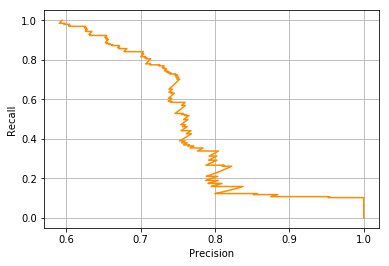

0.70 0.76
NO TH IS GOOD


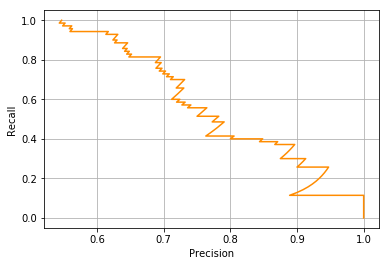



1 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.72 0.67
0.75 0.68
NO TH IS GOOD


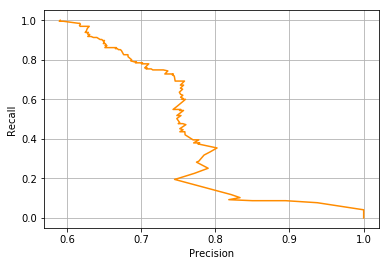

0.70 0.84
NO TH IS GOOD


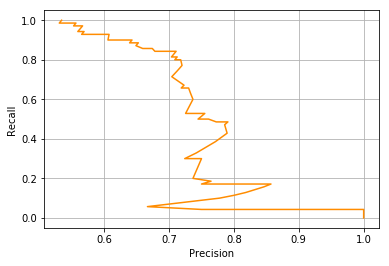

In [137]:
from sklearn.metrics import classification_report

def predictions_k(model, probs, th):
    return probs[:, 1] >= th

th = 0.6#0.576310286793

numSVMs = 0

small_models = [models[6], models[12]]
for i, model in enumerate(small_models):
    print(i, model)
    for j, df in enumerate([train_df, val_df, test_df]):
        X = df[X_cols_all].values
        Y = df[Y_cols].values
        
        if i >= numSVMs:
            probs = model.predict_proba(X)
            predictions = predictions_k(model, probs, th)
            report = classification_report(Y, predictions, output_dict = True)
            print('%.2f %.2f' %( report['1']['precision'], report['1']['recall']))
            if j == 1 or j == 2:
                plot_curves(model, probs, Y)
        else:
            predictions = model.predict(X)
            report = classification_report(Y, predictions, output_dict = True)
            print('%.2f %.2f' %( report['1']['precision'], report['1']['recall']))
            
        #print(pd.Series(predictions).value_counts())
        
        #print("-"*50)
    
    #print("-"*100)
    print('\n')

## Testing

In [77]:
from sklearn.metrics import classification_report

def predictions_k(model, X, k):
    probs = model.predict_proba(X)
    return probs[:, 1] >= k

for i, model in enumerate(models):
    print(j ,i)
    predictions = model.predict(test_df1[X_colss[j]].values)
    predictions = predictions_k(model, test_df1[X_colss[j]].values, 0.6)
    print(pd.Series(predictions).value_counts())
    print(classification_report(test_df1[Y_cols].values, predictions))

NameError: name 'j' is not defined

In [133]:
from sklearn.metrics import auc, roc_curve
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_curves(model, probs, ytrue):

    """
    fpr, tpr, thresholds = roc_curve(ytrue, probs, pos_label=1)
    score = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % score)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    """
    #print(ytrue.shape, probs.shape)
    precision, recall, thresholds = precision_recall_curve(ytrue, probs[:, 1])
    th = None
    pr = None
    re = None
    for i in range(len(thresholds)):
        p = precision[i]
        r = recall[i]
        t = thresholds[i]
        if p >= 0.75 and r >= 0.70:
            th = t
            pr = p
            re = r
    if th != None:
        print("THRESHOLD:", th, "at precision ", pr, ' and recall ', re)
    else:
        print("NO TH IS GOOD")
    
    plt.figure()
    plt.plot(precision, recall, color='darkorange')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.grid()
    plt.show()

    """
    thresholds = [0.25, 0.5, 0.75]
    for th in thresholds:
        #print(probs)
        predictions = [1 if prob > th else 0 for prob in probs]
        #predictions = model.predict(val_df[X_cols].values)
        print(pd.Series(predictions).value_counts())
        print(classification_report(ytrue, predictions))
    """
    
    


## Human Performance

In [ ]:
predictions = test_df_human.is_answerable_human.apply(lambda x: label_map[x]).values
labels = test_df_human.is_answerable.apply(lambda x: label_map[x]).values
print(classification_report(labels, predictions))

## Saving

In [136]:
with open('../../data/model_answerability.pkl', 'wb') as fp:
    pickle.dump(models[6], fp)

In [ ]:
with open('../../data/model_answerability.pkl', 'rb') as fp:
    model = pickle.load(fp)

# visualization

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets


for xcols in [X_cols_all, X_cols + ['w2v_sent', 'w2v_sent_mean', 'tfidf_sent', 'tfidf_sent_mean'], ['w2v_sent', 'tfidf_sent', 'w2v_sent_mean', 'tfidf_sent_mean']]:
    new_df = train_df[xcols]
    corr_matrix = new_df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    xcols = list(set(xcols) - set(to_drop))
    print(xcols)
    
    for df in [train_df, val_df, test_df]:
        X = df[xcols].values
        color = df[Y_cols].values

        # Next line to silence pyflakes. This import is needed.
        Axes3D

        n_points = len(X)
        #X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
        n_neighbors = 5
        n_components = 2

        fig = plt.figure(figsize=(15, 8))
        plt.suptitle("Manifold Learning with %i points, %i neighbors"
                     % (n_points, n_neighbors), fontsize=14)


        ax = fig.add_subplot(251, projection='3d')
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
        ax.view_init(4, -72)

        methods = ['standard', 'ltsa', 'modified']
        labels = ['LLE', 'LTSA', 'Modified LLE']

        for i, method in enumerate(methods):
            print("METHOD::::::" + method)
            t0 = time()
            Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                                eigen_solver='auto',
                                                method=method).fit_transform(X)
            t1 = time()
            print("%s: %.2g sec" % (methods[i], t1 - t0))

            ax = fig.add_subplot(252 + i)
            plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
            plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_major_formatter(NullFormatter())
            plt.axis('tight')

        t0 = time()
        Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
        t1 = time()
        print("Isomap: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(257)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("Isomap (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')


        t0 = time()
        mds = manifold.MDS(n_components, max_iter=100, n_init=1)
        Y = mds.fit_transform(X)
        t1 = time()
        print("MDS: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(258)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("MDS (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')


        t0 = time()
        se = manifold.SpectralEmbedding(n_components=n_components,
                                        n_neighbors=n_neighbors)
        Y = se.fit_transform(X)
        t1 = time()
        print("SpectralEmbedding: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(259)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
        Y = tsne.fit_transform(X)
        t1 = time()
        print("t-SNE: %.2g sec" % (t1 - t0))
        ax = fig.add_subplot(2, 5, 10)
        plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
        plt.title("t-SNE (%.2g sec)" % (t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis('tight')

        print("REACHED END")
        plt.show()

In [ ]:
plt.show()

In [ ]:
Y_cols

In [ ]:
train_df[xcols]